# Overlapping records in two datasets

The datasets `datasetA.csv` and `datasetB.csv` both contain (fake) personal information. There are 10k rows in each file, where each row is a personal
record with 12 data fields. The two datasets overlap partially. Two overlapping records may not match exactly, because of missing data fields, swapped fields, and typos or abbreviations.

We must derive an estimate for the number of overlapping records by matching the two datasets, using whatever smart techniques one can think of. On top of that, one must focus on methods that estimate the overlap without comparing all records in `datasetA` to all records in `datasetB`, since this brute-force approach is not feasible for large datasets.

The column names for the datasets are pretty straightforward, but are shown here as a summary:

- `first_name` : It is prone to abbreviations, initials only, typos and the input of nicknames.
- `last_name` : Suffers from similar issues as the first name. A potential candidate for record matching.
- `street_number` : Expect input errors. Not a good candidate for matchinf records, as it doesn't really have any uniqueness to it.
- `address_1` : This entry is not a bad candidate to do record matching, but it's prone to a lot of input errors and it can often be a long string, which makes exact matches between datasets less likely.
- `address_2` : It's not particularly useful as it's a mostly empty column.
- `town` : Here we have the same problems as the address column.
- `zipcode` : This is not a bad candidate for unique identifier.
- `state` : A categorical variable, but ends up being useless since it doesn't help identifying unique records. In datasetB in particular, this column is a mess.
- `date_of_birth` : It's prone to erros at input such as accidental swapping of numbers, but it's a great candidate for a unique identifier.
- `age` : Same as street number, really.
- `phone_number` : A good candidate for a unique identifier, specially if it's a mobile phone number. Input errors most likely to occur are number swaps.
- `soc_sec_id` : The ideal unique identifier for each individual. It is prone to typos and swapped numbers, but it's no doub the best starting point.



In [1]:
# install the more "unusual" packages
! pip install recordlinkage
! pip install missingno

In [2]:
# importing all necessary packages and dependencies
import time
import numpy as np
import pandas as pd
import recordlinkage
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [3]:
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 100)

<hr>

# Read datasets to match

We read datasets A and B into Pandas data frames A and B, respectively. For the sake of consistency in the terms used throughout the notebook, a **record** corresponds to a row of the data frame, which consists of a total of 12 **entries**, one for each column. All entries are in string format.

In [4]:
df_a = pd.read_csv('datasetA.csv', dtype=str)
df_a

,first_name,last_name,street_number,address_1,address_2,town,zipcode,state,date_of_birth,age,phone_number,soc_sec_id
0,lachlan,carmody,19,cade place,b,hamilton,4556,qld,19960616,31.0,02 92812617,2231206
1,sarah,tippins,3,keverstone circuit,NaN,woodpark,5540,qld,19280526,13.0,04 11695119,4612010
2,jessica,cheshire,12,halfrey circuit,NaN,jesmond,5172,nsw,19210205,26.0,02 02242599,3144617
3,natalia,tiller,73,eagle circuit,NaN,camden,5114,nt,19351203,33.0,07 91923807,1245778
4,lily,blackwell,18,bindel street,cambooya,oak flats,6230,nsw,19791106,NaN,04 45361517,2195128
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,jessica,clarke,52,NaN,msf 60,chelmsford,2566,nsw,19601129,NaN,03 40798285,4849937
9996,alessandra,moody,514,withnell circuit,NaN,narrogin,6207,vic,19210819,NaN,03 44448442,3068581
9997,darcie,burford,4,longerenong street,cambridge park,ballarat,NaN,nsw,19970902,33.0,04 31228862,9011666
9998,steven,white,70,investigator street,NaN,parkdale,2640,nsw,19280106,34.0,04 90977051,1490648


In [5]:
df_b = pd.read_csv('datasetB.csv', dtype=str)
df_b

,first_name,last_name,street_number,address_1,address_2,town,zipcode,state,date_of_birth,age,phone_number,soc_sec_id
0,baysen,scudds,11,helemontstreet,NaN,picton,4055,vic,19340808,29.0,03 82765568,1070893
1,jsohua,greej,30,muecke place,rockview,willetton,6023,wa,19164909,NaN,02 30027583,5782396
2,alicia,treumekr,24,hambidge crescent,NaN,bligh park,4216,qld,19000819,21.0,08 11540291,7788784
3,anna,reid,13,creswellsstreet,oxonia,parksie,4005,vim,19807429,NaN,03 26039045,1646214
4,dato,natasha,96,de burgh street,NaN,bayswater,4670,vic,19301075,23.0,08 76809985,4308494
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ema,britten,4,mugga fay,NaN,north beach,2211,ws,19150617,42.0,02 42401723,9558954
9996,keegan,herbdrt,56,dunbar sxtreet,dutch care hostel,como,4065,qld,NaN,30.0,NaN,8854365
9997,makenzie,huxldey,6,frencham place,NaN,longrgeach,5271,wa,19810514,29.0,07 53146771,4011126
9998,sybella,irizsrry,5,mckinlay street,NaN,vermont,3141,qld,19890909,35.0,08 92355273,7620274


<hr>

# Exploring the dataset

A quick look into the datasets shows just how messy it is. There's a large number of missing values, something we usually have to address before diving further into any sort of meaningful analysis. For the purposes of estimating the number of overlapping records, these missing entries won't be that problematic.

In [6]:
# dealing with missing values
display(df_a.isna().sum())
df_b.isna().sum()

first_name        191
last_name         197
street_number     223
address_1         368
address_2        6038
town              101
zipcode            84
state            1030
date_of_birth    1026
age              2040
phone_number      497
soc_sec_id          0
dtype: int64

first_name        285
last_name         332
street_number     332
address_1         558
address_2        6699
town              143
zipcode           113
state            1232
date_of_birth    1423
age              2307
phone_number      616
soc_sec_id          0
dtype: int64

We can get a visual representation of these missing values on each dataset to have a better understanding of just how messy they are:

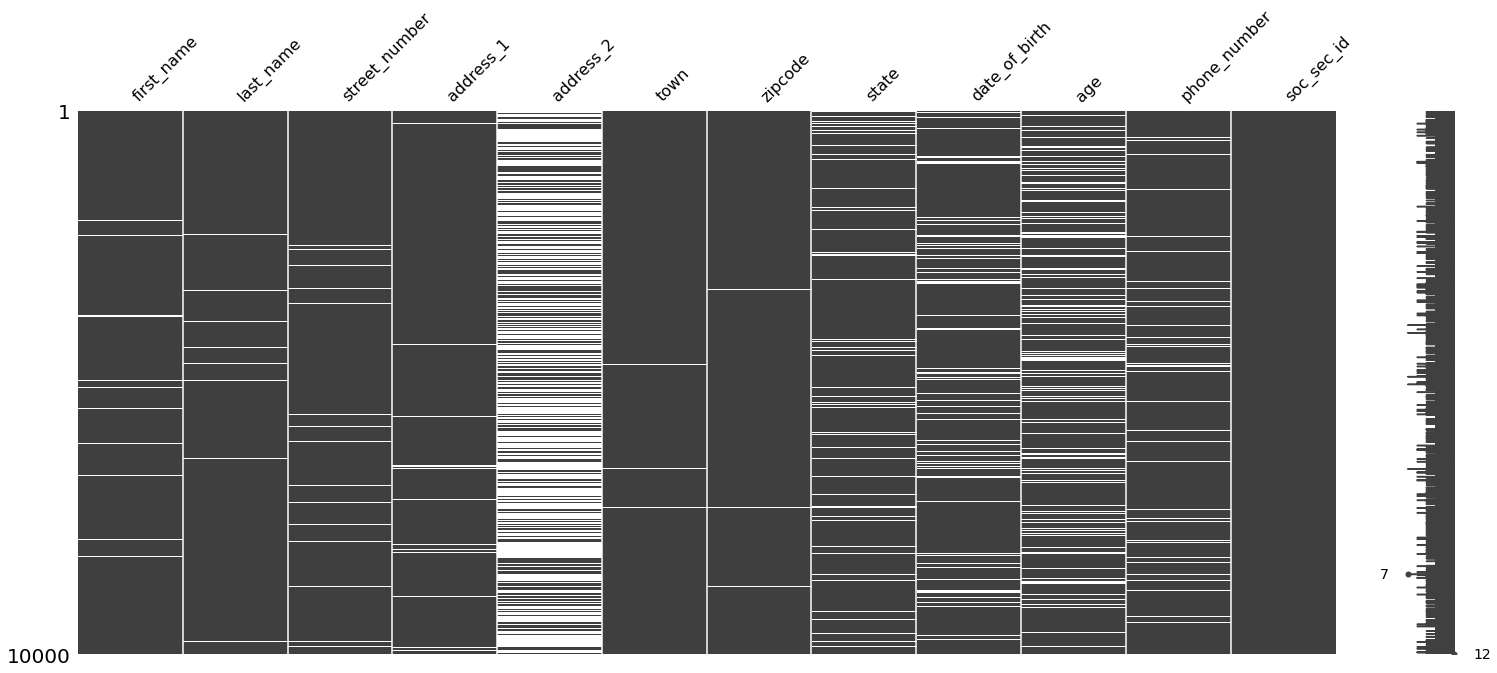

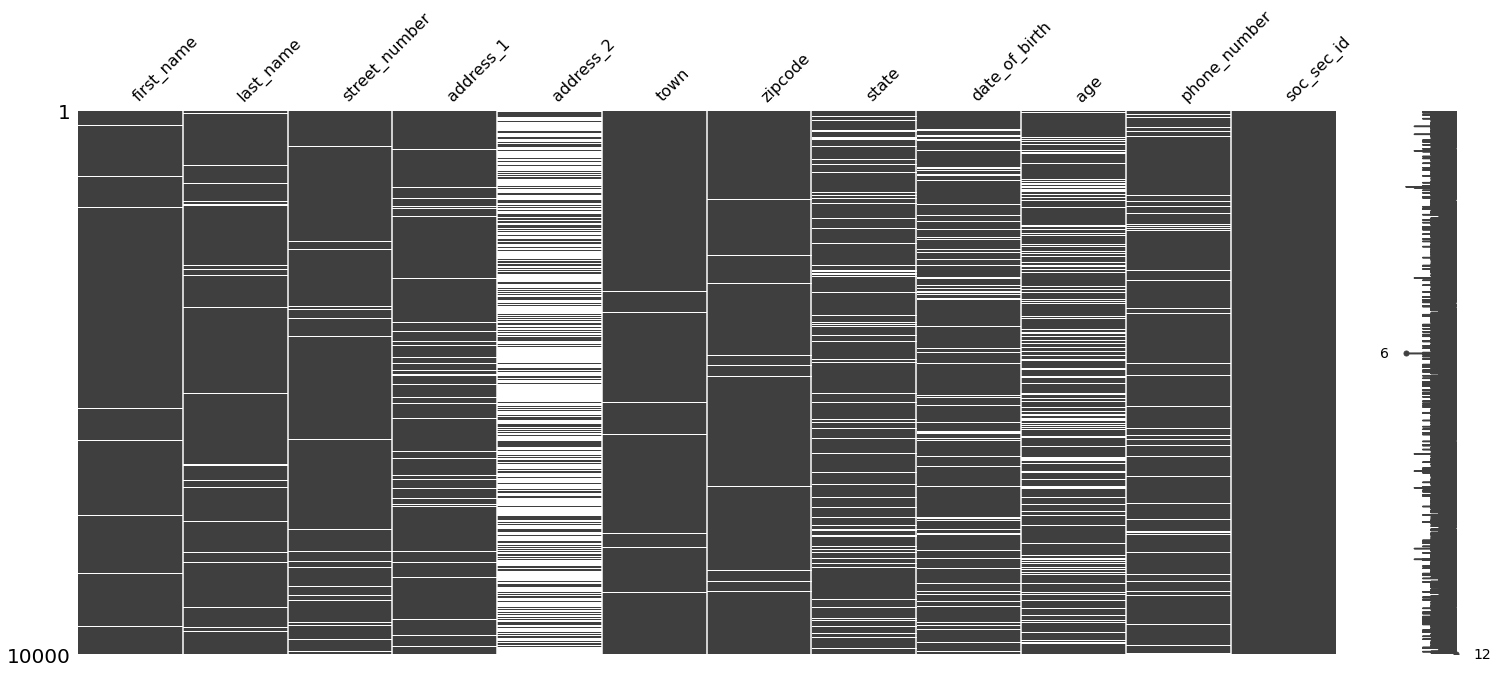

In [7]:
# visualizing the missing data
msno.matrix(df_a)
plt.show()

msno.matrix(df_b)
plt.show()

This shows us a few things. First and foremost, it's pretty easy to see just how erratic the missing entries are (missing entries represented in white). Cleaning and wrangling these datasets would prove to be a daunting task, but I won't be doing any of that. The missing values matrix shows just how useless the `address_2` column is (might as well remove it, but it doesn't really make any difference). The picture is quite fragmented for both datasets, with only the `soc_sec_id` column having no missing values (that's not to say that there are no input errors though).

An added feature of this visualization matrix, is the min/max bar to the right. This shows us the row(s) with minimum and maximum amount of missing values. From here we can see that we have rows with entries in all 12 columns for both datasets. At worst, `datasetA` has rows with only 7 entries (missing 5) and `datasetB` has rows with only 6 entries (missing 6).

A good obvious candidate for a merger here is the `soc_sec_id` column. One would expect this to be the ideal unique identifier, as the social security number is an individual reference. But alas, that is not the case.

In [8]:
# we'd expect all values to be unique... but no:
print("Unique entries of 'soc_sec_id' for datasetA: %s" % df_a['soc_sec_id'].nunique())
print("Unique entries of 'soc_sec_id' for datasetB: %s" % df_b['soc_sec_id'].nunique())

Unique entries of 'soc_sec_id' for datasetA: 9992
Unique entries of 'soc_sec_id' for datasetB: 9990


In [9]:
# this implies that some social security numbers are repeated (not necessarily wrong)
# because social security numbers are not unique, we skip these for now
display(df_a[df_a['soc_sec_id'].duplicated(keep=False)])
df_b[df_b['soc_sec_id'].duplicated(keep=False)]

,first_name,last_name,street_number,address_1,address_2,town,zipcode,state,date_of_birth,age,phone_number,soc_sec_id
89,kyle,snelling,42,maitland street,NaN,blackbutt,6532,wa,19910724,35.0,NaN,2750361
527,isabella,felstead,91,stace place,villa 43,comboyne,4305,qld,19090702,10.0,08 03086936,1395658
813,hamish,campbell,310,luxor,NaN,mclaren vale,2777,wa,19350117,24.0,03 21993503,5840968
824,alana,siviour,147,o'shanassy street,hawkins masonic vlge,west lakes,2444,NaN,19041025,31.0,NaN,6276980
1296,benjamin,grindley,62,paloona place,NaN,north st ives,2656,NaN,19321124,29.0,03 48438463,5828551
1427,naomi,NaN,21,trap road,NaN,taree,2795,sa,19321221,19.0,02 01109030,2750361
2162,rosie,gaskin,30,duffy street,NaN,vaucluse,2650,nsw,19900330,27.0,08 21770341,4161786
2589,joshua,heron,3,mulvany place,NaN,west wyalong,2763,qld,19430509,31.0,03 39827263,1395658
2869,benjamin,berry,294,barritt street,holmleigh,caulfield,3038,NaN,NaN,27.0,03 02642020,4381330
3608,ella,berry,302,macpherson street,NaN,macgregor,3942,vic,19950504,22.0,02 10994655,6276980


,first_name,last_name,street_number,address_1,address_2,town,zipcode,state,date_of_birth,age,phone_number,soc_sec_id
506,joshua,nicolle,2,NaN,NaN,annandale,2638,NaN,19631121,35.0,03 97449925,4750112
1509,luc,dolan,543,cunninghwm street,NaN,barragup,2815,NaN,19420208,31.0,04 57820708,4750112
1873,daniel,blacleell,45,elsey street,NaN,brewarfina,5013,NaN,NaN,19.0,02 34286188,5299632
2504,christian,carmody,680,filshie close,cosy corner,bay fennell,2095,nsw,19571010,10.0,04 27777189,5828551
2968,bennke,grindley,62,paloona place,NaN,north sixives,2656,NaN,19321124,29.0,03 48438463,5828551
3229,georgia,lombahrdi,44,pohlman street,NaN,watsonia,4058,qld,19430929,NaN,03 95941629,2060296
4361,jasmin,NaN,3,bellinger circuit,kilwinning,lower templestowe,4103,sa,19310510,30.0,07 55191958,4401203
4588,isabella,NaN,91,stace pace,NaN,comboyne,4305,qld,19090702,10.0,08 03086936,1395658
4749,leon,capel,57,ijong street,NaN,hopperscrossing,3796,qldk,19950302,53.0,03 44844056,5299632
5006,hamysh,campbell,315,luxor,NaN,mclaren vale,2777,wa,19350727,24.0,03 21993503,5840968


These duplicate entries for the social security show some very obvious missmatches. Easy to spot and filter out of our estimation, as I will show later, but I would recommend flagging these duplicates for a potential infestigation on identity theft since exact entries of social security numbers are suspicious.

Another column that I quickly looked into was the `state` column:

In [10]:
# listing the unique categories for 'state' column
print("Unique entries of 'state' in datasetA: %s\n" % df_a['state'].nunique())
print("State entries present in datasetA:")
print(df_a['state'].unique())

# for df_b it's not so nice...
print("\nUnique entries of 'state' in datasetB: %s" % df_b['state'].nunique())

Unique entries of 'state' in datasetA: 8

State entries present in datasetA:
['qld' 'nsw' 'nt' 'wa' 'vic' 'sa' 'act' nan 'tas']

Unique entries of 'state' in datasetB: 508



The amount of entries for the state column indicate manual input by the user. I made a rather naive attempt at comparing the strings and cleaning up the entries with the use of the `fuzzywuzzy` package, but that didn't really go anywhere. Also, the user data (even though it's fake) is clearly from Australia!

At this point I give up at trying any sort of data cleaning. I instead make a note to send an email to whoever was in charge of the form that gave rise to `datasetB` and *politely* ask them to do better in the future.

<hr>

# Examples of matches

The following records correspond to four pairs that are given as an example of what constitutes a match between `datasetA` and `datasetB`.

In [11]:
match_a = df_a.loc[[962, 2847, 7787, 6724]]
match_a

,first_name,last_name,street_number,address_1,address_2,town,zipcode,state,date_of_birth,age,phone_number,soc_sec_id
962,NaN,fleet,65,dartnell street,NaN,reynella,4215,nsw,19160720,23.0,02 46529999,1933859
2847,cameron,lademan,19,ebden street,NaN,williamstown,3165,nsw,19430515,29.0,08 39803141,8805927
7787,jamie,caruana,18,packham place,NaN,sunshine north,2096,nsw,19590202,23.0,08 71094666,5726002
6724,sophie,haupt,6,macrossan crescent,NaN,kyogle,2534,nsw,19071127,33.0,08 51432405,8085321


In [12]:
match_b = df_b.loc[[2704, 6268, 4843, 7373]]
match_b

,first_name,last_name,street_number,address_1,address_2,town,zipcode,state,date_of_birth,age,phone_number,soc_sec_id
2704,NaN,fleent,65,street datnell,NaN,reynella,4215,nsw,19160720,23.0,02 45629999,1933859
6268,camern,lademan,199,ebden street,NaN,bronte,3615,nsw,19430515,29.0,08 39803141,8805927
4843,jamie,caruana,18,packhamplace,NaN,sunshine north,2069,nzw,19590202,23.0,08 12512838,5726002
7373,sophie,haupt,6,macrossan yescent,NaN,kyogle,2534,nsw,NaN,33.0,08 51432405,4114985


One can easily see that these records match respectively, despite a multitude of input errors and missing values. I will be using these as a reference on how to classify matching pairings going forward.

<hr>

# Record matching

A very simple way of performing this type of evaluation is by making use of the `recordlinkage` package (for detailed documentation check [here](https://recordlinkage.readthedocs.io/en/latest/about.html)). It allows us to generate pairs between datasets and compare all entries between each other. The idea is quite simple, and initially I was going to use `fuzzywuzzy` or `jellyfish` packages to check the similarity between each entry and then using a certain similarity threshold, accept or reject the entries as probable matches.

After some searching, it turns out that `recordlinkage` does just that but it's specifically target at solving this type of record matching problem, so it's much simpler than writing a cross-checking algorithm from scratch, specially when it comes to generating the candidate pairings.

Overall, the method is simple: we pick two records between the datasets to be checked for probable similarities (or exact matches) on their entries. If enough entries are classified as exact, or they are similar enough that they are flagged as a match, then we label the entries as being a match. We then sum over all entries (the columns) and come up with a **similarity score** for that record pairing. If the similarity score is equal or above our **acceptance score** then we flag the record pairing as being a match and add it to our list of succesfully matched pairings.

The following function does just that.

In [13]:
def potential_matches(df1,df2,threshold=1,block=None):

    column_names = df1.columns

    # indexer object
    indexer = recordlinkage.Index()
    
    if block == None:
        # uses all possible pair combinations - careful!
        indexer.full()
    else:
        # the blocked column ends up being crucial!
        indexer.block(block)
    
    #create pairs
    pairs = indexer.index(df1,df2)
    
    # create a compare object
    compare = recordlinkage.Compare()
    
    if threshold == 1:
        #for exact matches:
        for col in column_names:
            # Find similar matches over the different columns
            compare.exact(col,col,label=col) 
    
    else:
        # for similarity matches:
        for col in column_names:
            # Find similar matches over the different columns
            compare.string(col,col,label=col,threshold = threshold) 
        
    # find matches
    potential_matches = compare.compute(pairs,df1,df2)
    
    return potential_matches

I start by a brute-force approach on the example record matches. There are 4 pairings that correspond to a valid match: *(962,2704) (2847,6268) (7787,4843)* and *(6724,7373)*. If we check all possible pair combinations that will result in a total of 16 pairs. This means a brute-force between two data frames with $N$ rows each, results in a total of $N^{2}$ pairings that have to be checked for entry similarities. For `datasetA` and `datasetB` we would be talking about an absurd 100M pairings to be checked...

For example purposes, I do this brute-force approach on the example matches, but we will need to lower the number of pairs to check, otherwise this is simply not feasible for large datasets.

In [14]:
# comparing dataframes with recordlinkage
exact_test = potential_matches(match_a,match_b) # checking for exact matches
possible_test = potential_matches(match_a,match_b,0.65) # checking for probable matches
merged_test = exact_test + possible_test # merging both for visualization

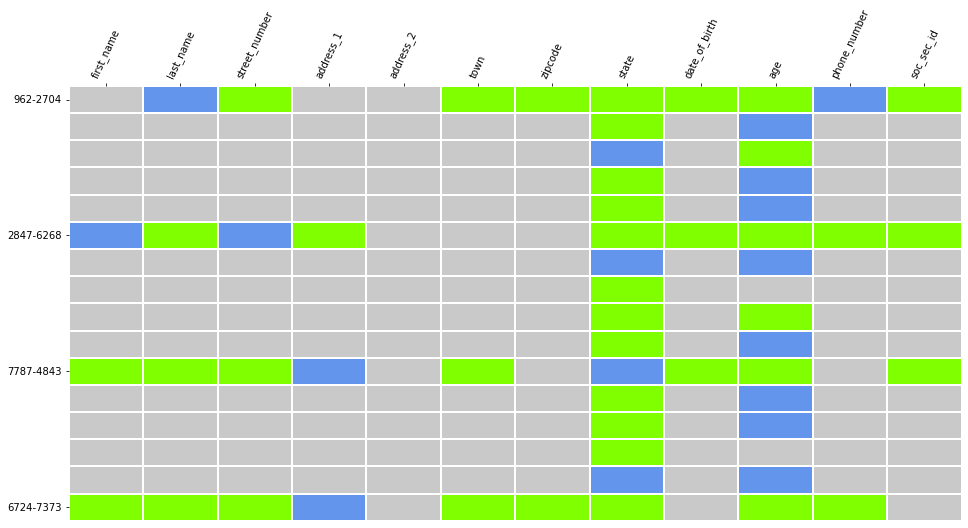

In [15]:
# custom discrete colors for matrix heatmap visualization
colors = ('#C9C9C9','#6495ED','#7FFF00')
cmap = LinearSegmentedColormap.from_list('custom', colors, len(colors))

plt.figure(figsize=(16,8))
p1 = sns.heatmap(merged_test,cbar=False,cmap=cmap,yticklabels=5,linewidths=2, linecolor='white')
p1.xaxis.set_ticks_position("top")
p1.set(ylabel=None)
plt.yticks(rotation=0)
plt.xticks(rotation=65)
plt.show()

Here we can see how the `potential_matches` function handles the pairs. The entries in green correspond to exact matches between the two datasets. The entries marked in blue correspond to potential matches between the two datasets. Note that this will depend on the method we use to perform string comparison and also on the threshold selected. I use the default setting of `recordlinkage` for string comparison, the Levenshtein distance (see [here](https://en.wikipedia.org/wiki/Levenshtein_distance) for a quick overview), and I use a similarity threshold of 0.65 which I picked after some experimentation with the outcome. 

By looking at the heatmap above, we can see how the different pairings are evaluated and from here, decide on an **acceptance score**.

In [16]:
# the sum of scores over the entire row
possible_test.sum(axis = 1)

962   2704    9.0
      6268    2.0
      4843    2.0
      7373    2.0
2847  2704    2.0
      6268    9.0
      4843    2.0
      7373    1.0
7787  2704    2.0
      6268    2.0
      4843    9.0
      7373    2.0
6724  2704    2.0
      6268    1.0
      4843    2.0
      7373    9.0
dtype: float64

In [17]:
possible_test.sum(axis=1).value_counts().sort_index(ascending=False)

9.0     4
2.0    10
1.0     2
dtype: int64

We can see the scores for each potential pairing, with the matching records scoring 9 and all other pairings scoring low. Going forward, I will set 9 as the acceptance score for a record pair to be flagged as a match, but this is a somewhat *safe* choice. Some matching records could still score lower and not be picked up because of our choice of acceptance score. 

<hr>

# Column blocking

For such large datasets, checking all possible pair combinations is simply not feasible. In order to avoid this issue, we block a specific column at a time and generate pairs from there. **Blocking** simply means that we only consider pairs that have an exact match on the entries of a specific column. This will greatly decrease the number of generated pairs for us to check for entry similarity, improving performance.

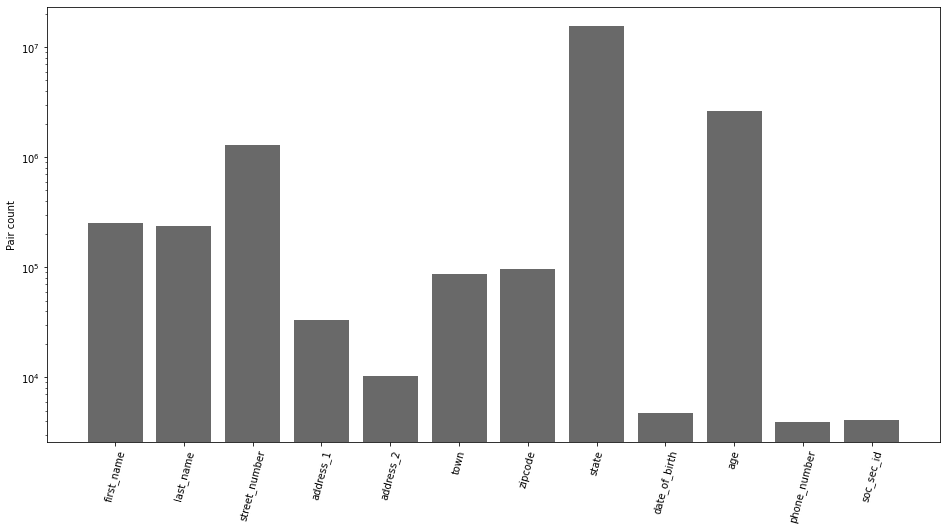

In [18]:
def pairs(df1,df2):

    column_names = df1.columns.tolist()
    pairings = []

    for col in column_names:
    
        # indexer object
        indexer = recordlinkage.Index()
        indexer.block(col)
    
        #create pairs
        pairs = indexer.index(df1,df2)
        pairings.append(len(pairs))
    
    return column_names,pairings

blocked_columns,pairings = pairs(df_a,df_b)

y_pos = np.arange(len(blocked_columns))

plt.figure(figsize=(16,8))
plt.bar(y_pos, pairings,color='dimgray')
plt.xticks(y_pos, blocked_columns)
plt.ylabel('Pair count')
plt.xticks(rotation=75)
plt.yscale('log')
plt.show()

The plot above displays the total number of pairs generated from blocking a specific column. Note that it is displayed in logarithmic scale.

We can also print these numbers down bellow:

In [19]:
print("Number of pairings generated by blocking a given column:")

for i in range(len(blocked_columns)):
    
    print("%s: %s" % (blocked_columns[i],pairings[i]))

Number of pairings generated by blocking a given column:
first_name: 254413
last_name: 239687
street_number: 1294039
address_1: 33503
address_2: 10265
town: 86555
zipcode: 96596
state: 15483960
date_of_birth: 4718
age: 2611775
phone_number: 3953
soc_sec_id: 4113


From here we can immediately exclude the columns `street_number`, `state` and `age` as potential blocking candidates, since the number of generated pairs goes into the millions. This is not a good option as we'd quickly run out of memory to perform checks on so many pairs. All other columns have pairings within a reasonable number, though some overlap in generated pairings is to be expected.

In [20]:
def blocking(df1,df2,threshold,block_columns,limit):

    matches = []
    
    for blocker in block_columns:
    
        block_test = potential_matches(df1,df2,threshold,blocker)
        block_matched = block_test[(block_test.sum(axis=1) >= limit)]
        valid_pairs = block_matched.index
    
        for pair in valid_pairs:
            
            if pair not in matches:
                matches.append(pair)

    return matches

Here I chose to block a total of three columns, which were the ones that made the most sense and also the ones that return a lower number of pairs to check, thus improving performance.

The main point here is which columns to block in order to form pairs. These are the ones that are more specific/unique to each individual, and return the lower number of possible pairs while also retaining significance. I drop the `first_name`, `last_name` and `address_1` because I think they are more difficult to check for similarities than the numerical columns. The reason is that the numerical columns are more consistent on the lenght of the strings, due to the data format. First names, surnames and addresses are prone to input errors that can lead to comparing entries with significant length differences, making certain checks quite useless. Although, for completeness, one could definitely add them (as is done at the end). 

Of course that by blocking over all columns we make our search more complete, but for the sake of estimating the number of record pairings these three are sufficient.

Note that there are columns that are not good candidates. As discussed before, `address_2` is pretty much useless. There is also the `state` column, which is a categorical entry with a maximum of eight possible values (when typos are not even taken into account). Blocking this column would result in a wooping 1548396 pairs, we'd quickly run out of memory and defeat the whole purpose of this exercise. The `age` column is also off limits; the resulting pairs are too large and it's also not a good unique identifier. Same applies to the `street_number` column.

In [21]:
block_columns = ['soc_sec_id','date_of_birth','phone_number']
acceptance_score = 9

start_time = time.time()

matches = blocking(df_a,df_b,0.65,block_columns,acceptance_score)
matches.sort()  # to have pairs neatly arranged

print("Matching algorithm completed in: %s seconds." % (time.time() - start_time))
print("Resulting matches: %s" % len(matches))    # number of matching records

Matching algorithm completed in: 1.8012089729309082 seconds.
Resulting matches: 4158


The value we select for the acceptance score will have an obvious impact on the number of resulting matches. In the table bellow I show the results of the previous cell when ran for different acceptance scores:

| Acceptance Score | Resulting Matches  |
|------------------|--------------------|
| 6                | 4961               |
| 7                | 4937               |
| 8                | 4761               |
| 9                | 4158               |
| 10               | 2775               |
| 11               | 1147               |
| 12               | 194                |

Please note that the actual calculation of all the values on the table is not performed here to avoid computational bloat when running the notebook.

An acceptance score bellow 6 is not advisable, as we won't be validating enough entries to confidently say that there's a match between the rows.

For fun, bellow are some examples of potential false positives (records that would pass this minimum acceptance score):

The housemate:
    
| first_name | last_name | street_number | address_1 | address_2 | town | zipcode | state | date_of_birth | age | phone_number | soc_sec_id | 
|------------|-----------|---------------|-----------|-----------|------|---------|-------|---------------|-----|--------------|------------|
| ❌        | ❌        | ✔️             | ✔️         | ✔️         | ✔    | ✔       | ✔    | ❌            | ❌  | ❌          | ❌         |

The relative who happens to have the same name as you (based on a true story):

| first_name | last_name | street_number | address_1 | address_2 | town | zipcode | state | date_of_birth | age | phone_number | soc_sec_id | 
|------------|-----------|---------------|-----------|-----------|------|---------|-------|---------------|-----|--------------|------------|
| ✔️          | ✔️         | ❌           | ✔        | ❌       | ✔    | ✔       | ✔     | ❌           | ❌  | ❌          | ❌         |

The housemate who also happens to be your twin (or you're both living at your parents):
    
| first_name | last_name | street_number | address_1 | address_2 | town | zipcode | state | date_of_birth | age | phone_number | soc_sec_id | 
|------------|-----------|---------------|-----------|-----------|------|---------|-------|---------------|-----|--------------|------------|
| ❌        | ✔️         | ✔️             | ✔️         | ✔️         | ✔    | ✔       | ✔     | ✔️             | ✔️  | ❌          | ❌         |

We could come up with these examples forever and get nowhere, so picking an acceptance score at 9 is perfectly reasonable and goes along with the scores given by the example matching records we saw before.

We can also show that increasing the number of blocked columns won't really add much to the table of resulting matches. This is done bellow, simply to demonstrate that there's a substantial increase in computational time with only a minor changes to the estimated number of matching records:

In [22]:
block_columns = ['soc_sec_id','zipcode','date_of_birth','phone_number','last_name','first_name','address_1','address_2','town']
acceptance_score = 9 

start_time = time.time()

matches = blocking(df_a,df_b,0.65,block_columns,acceptance_score)
matches.sort()  # to have pairs neatly arranged

print("Matching algorithm completed in: %s seconds." % (time.time() - start_time))
print("Resulting matches: %s" % len(matches))    # number of matching records

Matching algorithm completed in: 69.23871541023254 seconds.
Resulting matches: 4182


| Acceptance Score | Resulting Matches  |
|------------------|--------------------|
| 6                | 4996               |
| 7                | 4972               |
| 8                | 4794               |
| 9                | 4182               |
| 10               | 2790               |
| 11               | 1153               |
| 12               | 195                |

This would mean that there are about 42-50% overlapping records between `datasetA` and `datasetB`. With our relatively safe acceptance score at 9, we end up with 4182 matching records.

To finish, I would like to store these entries in a .csv file. Since the function that I wrote only returns the index pairings, and not the actual data frame to avoid memory bloat, I must extract the entries and store them in a new data frame. This is done bellow.

In [23]:
# create an empty dataframe to append the rows to
df_a_pairs = pd.DataFrame(columns=df_a.columns)
df_b_pairs = pd.DataFrame(columns=df_b.columns)

# appending the records to the respecting dataframes
for i in range(len(matches)):
    
    df_a_pairs = df_a_pairs.append(df_a.iloc[[matches[i][0]]])
    df_b_pairs = df_b_pairs.append(df_b.iloc[[matches[i][1]]])
    
# reseting the indices in order to merge correctly
df_a_pairs = df_a_pairs.reset_index(drop=True)
df_b_pairs = df_b_pairs.reset_index(drop=True)

# merging and column sorting as per the example
df_match = df_a_pairs.merge(df_b_pairs, how='inner', left_index=True, right_index=True, suffixes=('_a', '_b'))
df_match = df_match[sorted(df_match.columns)]

# saving to .csv format
df_match.to_csv("matching_records.csv")

<hr>

## Author:

[Bruno Rodrigues](https://www.linkedin.com/in/kouniam/)